In [1]:
import SimPEG as simpeg
import simpegMT as simpegmt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Setup the modelling
# Setting up 1D mesh and conductivity models to forward model data.

# Frequency
nFreq = 31
freqs = np.logspace(3,-3,nFreq)
# Set mesh parameters
ct = 10
air = simpeg.Utils.meshTensor([(ct,25,1.3)])
core = np.concatenate( (  np.kron(simpeg.Utils.meshTensor([(ct,5,-1.2)]),np.ones((3,))) , simpeg.Utils.meshTensor([(ct,5)]) ) )
bot = simpeg.Utils.meshTensor([(core[0],25,-1.3)])
x0 = -np.array([np.sum(np.concatenate((core,bot)))])
# Make the model
m1d = simpeg.Mesh.TensorMesh([np.concatenate((bot,core,air))], x0=x0)

# Setup model varibles
active = m1d.vectorCCx<0.
layer1 = (m1d.vectorCCx<-200.) & (m1d.vectorCCx>=-600.)
layer2 = (m1d.vectorCCx<-2000.) & (m1d.vectorCCx>=-4000.)
# Set the conductivity values
sig_half = 2e-3
sig_air = 1e-8
sig_layer1 = .2
sig_layer2 = .2
# Make the true model
sigma_true = np.ones(m1d.nCx)*sig_air
sigma_true[active] = sig_half
sigma_true[layer1] = sig_layer1
sigma_true[layer2] = sig_layer2
# Extract the model 
m_true = np.log(sigma_true[active])
# Make the background model
sigma_0 = np.ones(m1d.nCx)*sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

# Set the mapping
actMap = simpeg.Maps.ActiveCells(m1d, active, np.log(1e-8), nC=m1d.nCx)
mappingExpAct = simpeg.Maps.ExpMap(m1d) * actMap

In [3]:
## Setup the layout of the survey, set the sources and the connected receivers

# Receivers 
rxList = []
for rxType in ['z1dr','z1di']:
    rxList.append(simpegmt.SurveyMT.RxMT(simpeg.mkvc(np.array([0.0]),2).T,rxType))
# Source list
srcList =[]
for freq in freqs:
        srcList.append(simpegmt.SurveyMT.srcMT_polxy_1Dprimary(rxList,freq))
# Make the survey
survey = simpegmt.SurveyMT.SurveyMT(srcList)
survey.mtrue = m_true
# Set the problem
problem = simpegmt.ProblemMT1D.eForm_psField(m1d,sigmaPrimary=sigma_0,mapping=mappingExpAct)
from pymatsolver import MumpsSolver
problem.solver = MumpsSolver
problem.pair(survey)

In [4]:
## Read the data
std = 0.05 # 5% std
# Load the files if they exist
if os.path.isfile('MT1D_dtrue.npy') and os.path.isfile('MT1D_dobs.npy'):
    d_true = np.load('MT1D_dtrue.npy')
    d_obs = np.load('MT1D_dobs.npy')
else:
    # Forward model
    d_true = survey.dpred(m_true)
    np.save('MT1D_dtrue.npy',d_true)
    d_obs = d_true + (std*abs(d_true)*np.random.randn(*d_true.shape))
    np.save('MT1D_dobs.npy',d_obs)
# Assign the datas to the survey object
survey.dtrue = d_true
survey.dobs = d_obs
survey.std = np.abs(survey.dobs*std) + 0.01*np.linalg.norm(survey.dobs)
# Assign the data weight
survey.Wd = 1./survey.std

In [5]:
## Setup the inversion proceedure

# Define a counter
C =  simpeg.Utils.Counter()
# Set the optimization
opt = simpeg.Optimization.InexactGaussNewton(maxIter = 30)
opt.counter = C
opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = simpeg.DataMisfit.l2_DataMisfit(survey)
# Regularization
# Note: We want you use a mesh the corresponds to the domain we want to solve, the active cells.
if True:
    regMesh = simpeg.Mesh.TensorMesh([m1d.hx[problem.mapping.sigmaMap.maps[-1].indActive]],m1d.x0)
    reg = simpeg.Regularization.Tikhonov(regMesh)
# else:
#     reg = simpeg.Regularization.Tikhonov(m1d,mapping=mapAct)
reg.smoothModel = False
reg.alpha_s = 1e-8
reg.alpha_x = 1.
# Inversion problem
invProb = simpeg.InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta cooling
beta = simpeg.Directives.BetaSchedule()
betaest = simpeg.Directives.BetaEstimate_ByEig(beta0_ratio=0.75)
saveModel = simpeg.Directives.SaveModelEveryIteration()
saveModel.fileName = 'Inversion_NoStoppingregMesh_smoothFalse'
# Create an inversion object
inv = simpeg.Inversion.BaseInversion(invProb, directiveList=[beta,betaest,saveModel]) 


In [6]:
# Run the inversion, given the background model as a start.
mopt = inv.run(m_0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.l2_DataMisfit is creating default weightings for Wd.
SimPEG.SaveModelEveryIteration will save your models as: '###-Inversion_NoStoppingregMesh_smoothFalse.npy'
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  7.58e+05  5.84e+06  0.00e+00  5.84e+06    1.45e+06      0              
   1  7.58e+05  6.42e+05  2.33e-04  6.43e+05    1.64e+05      0              
   2  7.58e+05  6.95e+04  7.43e-04  7.00e+04    2.00e+04      0   Skip BFGS  
   3  9.47e+04  9.80e+03  1.31e-03  9.92e+03    2.87e+03      0   Skip BFGS  
   4  9.47e+04  4.94e+03  5.58e-03  5.47e+03    3.72e+02      0   Skip BFGS  
   5  9.47e+04  4.62

In [7]:
modList = []
modFiles = glob('*Inversion_NoStopping.npy')
modFiles.sort()
for f in modFiles:
    modList.append(np.load(f))

AttributeError: 'Figure' object has no attribute 'supplot'

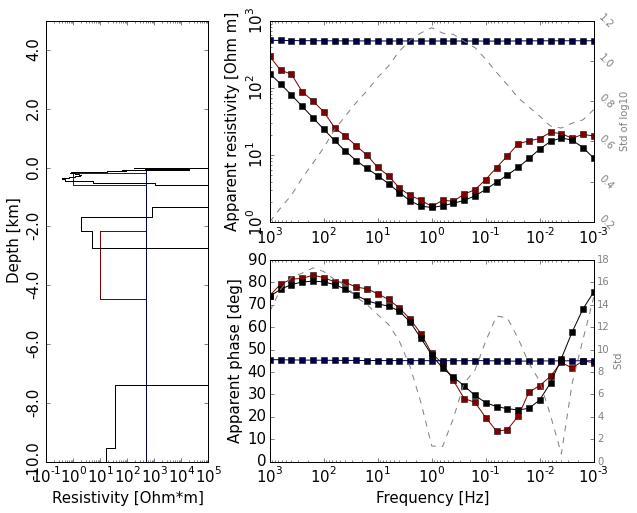

In [22]:
%matplotlib inline
fig = simpegmt.Utils.dataUtils.plotMT1DModelData(problem,[m_0,mopt])
fig.supplot
plt.show()

In [9]:
%matplotlib qt
simpegmt.Utils.dataUtils.plotMT1DModelData(problem,modList)
plt.show()

In [10]:
# %matplotlib qt
# simpegmt.Utils.dataUtils.plotMT1DModelData(problem,modList[-3:-1])
# plt.show()

In [11]:
np.linalg.norm(mopt - reg.mref)


78.694562868192662

In [12]:
reg.mref

array([-6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081])

In [13]:
regMesh.gridN

array([ -7.62973638e+04,  -5.87387576e+04,  -4.52321375e+04,
        -3.48424297e+04,  -2.68503468e+04,  -2.07025907e+04,
        -1.59735476e+04,  -1.23358221e+04,  -9.53757167e+03,
        -7.38507138e+03,  -5.72930192e+03,  -4.45563311e+03,
        -3.47588787e+03,  -2.72223768e+03,  -2.14250677e+03,
        -1.69655992e+03,  -1.35352387e+03,  -1.08965000e+03,
        -8.86670089e+02,  -7.30531699e+02,  -6.10425246e+02,
        -5.18035666e+02,  -4.46966758e+02,  -3.92298368e+02,
        -3.50245760e+02,  -3.17897600e+02,  -2.93014400e+02,
        -2.68131200e+02,  -2.43248000e+02,  -2.22512000e+02,
        -2.01776000e+02,  -1.81040000e+02,  -1.63760000e+02,
        -1.46480000e+02,  -1.29200000e+02,  -1.14800000e+02,
        -1.00400000e+02,  -8.60000000e+01,  -7.40000000e+01,
        -6.20000000e+01,  -5.00000000e+01,  -4.00000000e+01,
        -3.00000000e+01,  -2.00000000e+01,  -1.00000000e+01,
        -5.82076609e-11])

In [14]:
m1d.gridN[active]

array([ -7.62973638e+04,  -5.87387576e+04,  -4.52321375e+04,
        -3.48424297e+04,  -2.68503468e+04,  -2.07025907e+04,
        -1.59735476e+04,  -1.23358221e+04,  -9.53757167e+03,
        -7.38507138e+03,  -5.72930192e+03,  -4.45563311e+03,
        -3.47588787e+03,  -2.72223768e+03,  -2.14250677e+03,
        -1.69655992e+03,  -1.35352387e+03,  -1.08965000e+03,
        -8.86670089e+02,  -7.30531699e+02,  -6.10425246e+02,
        -5.18035666e+02,  -4.46966758e+02,  -3.92298368e+02,
        -3.50245760e+02,  -3.17897600e+02,  -2.93014400e+02,
        -2.68131200e+02,  -2.43248000e+02,  -2.22512000e+02,
        -2.01776000e+02,  -1.81040000e+02,  -1.63760000e+02,
        -1.46480000e+02,  -1.29200000e+02,  -1.14800000e+02,
        -1.00400000e+02,  -8.60000000e+01,  -7.40000000e+01,
        -6.20000000e+01,  -5.00000000e+01,  -4.00000000e+01,
        -3.00000000e+01,  -2.00000000e+01,  -1.00000000e+01])

In [15]:
self = reg
r1 = self.W * ( self.mapping * (m_0) )
r2 = self.Ws * ( self.mapping * (self.mref) )

In [16]:
( self.mapping * (m_0) )

array([-6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081,
       -6.2146081, -6.2146081, -6.2146081, -6.2146081, -6.2146081])

In [17]:
self.Ws

<45x45 sparse matrix of type '<type 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [18]:
self.mapping

In [19]:
0.5*(r1.dot(r1)-r2.dot(r2))

-1.7347234759768071e-18

In [20]:
r1.dot(r1)

0.029467074824486239

In [21]:
r2.dot(r2)

0.029467074824486243